## API Data Extraction

In [1]:
#import libaries

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
#use the requests library, and save those client credentials from our Spotify project’s pag
import requests
CLIENT_ID = ''
CLIENT_SECRET = ''

In [3]:
#pass an access token
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [4]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [5]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '6y0igZArWVi6Iz0rj35c1Y'

# actual GET request with proper header
r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)

In [6]:
r = r.json()
r

{'danceability': 0.54,
 'energy': 0.59,
 'key': 0,
 'loudness': -4.359,
 'mode': 1,
 'speechiness': 0.0528,
 'acousticness': 0.446,
 'instrumentalness': 0,
 'liveness': 0.14,
 'valence': 0.267,
 'tempo': 119.878,
 'type': 'audio_features',
 'id': '6y0igZArWVi6Iz0rj35c1Y',
 'uri': 'spotify:track:6y0igZArWVi6Iz0rj35c1Y',
 'track_href': 'https://api.spotify.com/v1/tracks/6y0igZArWVi6Iz0rj35c1Y',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6y0igZArWVi6Iz0rj35c1Y',
 'duration_ms': 234910,
 'time_signature': 4}

In [7]:
%%html
<iframe src="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features" width="1200" height="1000"></iframe>

In [8]:
#artist id - drake
artist_id = '36QJpDe2go2KgaRleHCDTp'

# pull all artists albums
r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50})
d = r.json()

In [9]:
for album in d['items']:
    print(album['name'], ' --- ', album['release_date'])

The Complete BBC Sessions (Remastered)  ---  2016-09-16
Physical Graffiti (Deluxe Edition)  ---  2015-02-24
Celebration Day  ---  2012-11-19
Mothership (Remastered)  ---  2007
How the West Was Won (Remaster)  ---  2003-05-27
Coda (Deluxe Edition)  ---  1982-11-19
Coda (Remaster)  ---  1982-11-19
In Through the out Door (Deluxe Edition)  ---  1979-08-15
In Through the out Door (Remaster)  ---  1979-08-15
The Song Remains the Same (Remaster)  ---  1976-10-22
Presence (Deluxe Edition)  ---  1976-03-31
Presence (Remaster)  ---  1976-03-31
Physical Graffiti (Remaster)  ---  1975-02-24
Physical Graffiti (1994 Remaster)  ---  1975-02-24
Physical Graffiti (Deluxe Edition)  ---  1975-02-24
Houses of the Holy (Deluxe Edition)  ---  1973-03-28
Houses of the Holy (Remaster)  ---  1973-03-28
Led Zeppelin IV (Deluxe Edition)  ---  1971-11-08
Led Zeppelin IV (Remaster)  ---  1971-11-08
Led Zeppelin III (Deluxe Edition)  ---  1970-10-05
Led Zeppelin III (Deluxe Edition)  ---  1970-10-05
Led Zeppelin I

In [10]:
data = []   # will hold all track info
albums = [] # to keep track of duplicates

# loop over albums and get all tracks
for album in d['items']:
    album_name = album['name']

    # here's a hacky way to skip over albums we've already grabbed
    trim_name = album_name.split('(')[0].strip()
    if trim_name.upper() in albums or int(album['release_date'][:4]) > 1983:
        continue
    albums.append(trim_name.upper()) # use upper() to standardize
    
    # this takes a few seconds so let's keep track of progress    
    print(album_name)
    
    # pull all tracks from this album
    r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
    tracks = r.json()['items']
    
    for track in tracks:
        # get audio features (key, liveness, danceability, ...)
        f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
            headers=headers)
        f = f.json()
        
        # combine with album info
        f.update({
            'track_name': track['name'],
            'album_name': album_name,
            'short_album_name': trim_name,
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        data.append(f)

Coda (Deluxe Edition)
In Through the out Door (Deluxe Edition)
The Song Remains the Same (Remaster)
Presence (Deluxe Edition)
Physical Graffiti (Remaster)
Houses of the Holy (Deluxe Edition)
Led Zeppelin IV (Deluxe Edition)
Led Zeppelin III (Deluxe Edition)
Led Zeppelin II (Deluxe Edition)
Led Zeppelin (Deluxe Edition)


In [11]:
df = pd.DataFrame(data)

In [12]:
# convert release_date to an actual date, and sort by it
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

In [13]:
df.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id
159,0.209,0.617,2,-10.246,1,0.0484,0.000518,0.096700,0.6450,0.370,...,spotify:track:3A5GuTgDl58yS4HucB2IkX,https://api.spotify.com/v1/tracks/3A5GuTgDl58y...,https://api.spotify.com/v1/audio-analysis/3A5G...,674573,3,"How Many More Times - Live in Paris, 1969",Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,5HNlYbQp7wKbKscWy7ceMp
143,0.445,0.703,9,-9.783,1,0.0859,0.082800,0.000003,0.0782,0.633,...,spotify:track:0FGhq1atMRDXBydpC4MlK2,https://api.spotify.com/v1/tracks/0FGhq1atMRDX...,https://api.spotify.com/v1/audio-analysis/0FGh...,166107,4,Good Times Bad Times - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,5HNlYbQp7wKbKscWy7ceMp
144,0.411,0.466,4,-11.537,0,0.0332,0.375000,0.000085,0.1420,0.158,...,spotify:track:6bTvFs7doZSipBS7P7Epoo,https://api.spotify.com/v1/tracks/6bTvFs7doZSi...,https://api.spotify.com/v1/audio-analysis/6bTv...,402761,4,Babe I'm Gonna Leave You - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,5HNlYbQp7wKbKscWy7ceMp
145,0.366,0.560,11,-10.361,0,0.0633,0.647000,0.007030,0.1800,0.361,...,spotify:track:0dF5j0jgcJBgMGGsT8drku,https://api.spotify.com/v1/tracks/0dF5j0jgcJBg...,https://api.spotify.com/v1/audio-analysis/0dF5...,388467,3,You Shook Me - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,5HNlYbQp7wKbKscWy7ceMp
146,0.240,0.546,2,-10.026,1,0.0548,0.089800,0.006480,0.0898,0.429,...,spotify:track:68bhDgGmkopBrSHn9Ywstn,https://api.spotify.com/v1/tracks/68bhDgGmkopB...,https://api.spotify.com/v1/audio-analysis/68bh...,388667,4,Dazed and Confused - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,5HNlYbQp7wKbKscWy7ceMp


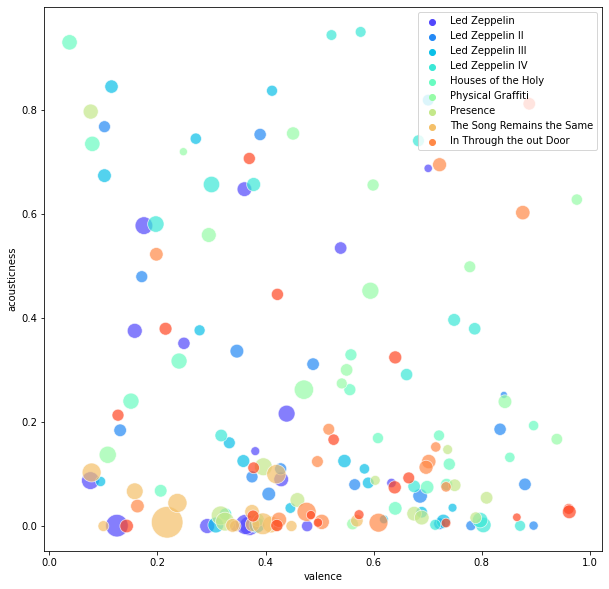

In [14]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df, x='valence', y='acousticness', 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

## Import Streamings

In [15]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

In [16]:
client_id = ''
client_secret = ''
client_credentials_manager = SpotifyClientCredentials(client_id = client_id , client_secret = client_secret)


In [17]:
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)


In [19]:
df=pd.read_csv('songs_normalize.csv',encoding = 'latin-1')

FileNotFoundError: [Errno 2] No such file or directory: 'songs_normalize.csv'